In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

ModuleNotFoundError: No module named 'utils'

#### write KMeans Class

In [ ]:
class MyKMeans(BaseEstimator):
     def __init__(self, n_clusters=8, n_init=10,max_iter=300, tol=1e-4,random_state=None ):

        self.n_clusters = n_clusters #n_samples should be >= n_clusters
        self.max_iter = max_iter #Number of iterations should be a positive number
        self.tol = tol
        self.n_init = n_init #must be bigger than zero
        self.random_state = random_state
     
     def fit(self, X, y=None, sample_weight=None):
        
               
        # Validate init array
        init = self.init
        if hasattr(init, '__array__'):
            init = check_array(init, dtype=X.dtype.type, copy=True)
            _validate_center_shape(X, self.n_clusters, init)

            if n_init != 1:
                warnings.warn(
                    'Explicit initial center position passed: '
                    'performing only one init in k-means instead of n_init=%d'
                    % n_init, RuntimeWarning, stacklevel=2)
                n_init = 1

        # subtract of mean of x for more accurate distance computations
        if not sp.issparse(X):
            X_mean = X.mean(axis=0)
            # The copy was already done above
            X -= X_mean

            if hasattr(init, '__array__'):
                init -= X_mean

        # precompute squared norms of data points
        x_squared_norms = row_norms(X, squared=True)

        best_labels, best_inertia, best_centers = None, None, None
        algorithm = self.algorithm
        if self.n_clusters == 1:
            # elkan doesn't make sense for a single cluster, full will produce
            # the right result.
            algorithm = "full"
        if algorithm == "auto":
            algorithm = "full" if sp.issparse(X) else 'elkan'
        if algorithm == "full":
            kmeans_single = _kmeans_single_lloyd
        elif algorithm == "elkan":
            kmeans_single = _kmeans_single_elkan
        else:
            raise ValueError("Algorithm must be 'auto', 'full' or 'elkan', got"
                             " %s" % str(algorithm))

        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        if effective_n_jobs(self.n_jobs) == 1:
            # For a single thread, less memory is needed if we just store one
            # set of the best results (as opposed to one set per run per
            # thread).
            for seed in seeds:
                # run a k-means once
                labels, inertia, centers, n_iter_ = kmeans_single(
                    X, sample_weight, self.n_clusters,
                    max_iter=self.max_iter, init=init, verbose=self.verbose,
                    precompute_distances=precompute_distances, tol=tol,
                    x_squared_norms=x_squared_norms, random_state=seed)
                # determine if these results are the best so far
                if best_inertia is None or inertia < best_inertia:
                    best_labels = labels.copy()
                    best_centers = centers.copy()
                    best_inertia = inertia
                    best_n_iter = n_iter_
        else:
            # parallelisation of k-means runs
            results = Parallel(n_jobs=self.n_jobs, verbose=0)(
                delayed(kmeans_single)(
                    X, sample_weight, self.n_clusters,
                    max_iter=self.max_iter, init=init,
                    verbose=self.verbose, tol=tol,
                    precompute_distances=precompute_distances,
                    x_squared_norms=x_squared_norms,
                    # Change seed to ensure variety
                    random_state=seed
                )
                for seed in seeds)
            # Get results with the lowest inertia
            labels, inertia, centers, n_iters = zip(*results)
            best = np.argmin(inertia)
            best_labels = labels[best]
            best_inertia = inertia[best]
            best_centers = centers[best]
            best_n_iter = n_iters[best]

        if not sp.issparse(X):
            if not self.copy_x:
                X += X_mean
            best_centers += X_mean

        distinct_clusters = len(set(best_labels))
        if distinct_clusters < self.n_clusters:
            warnings.warn(
                "Number of distinct clusters ({}) found smaller than "
                "n_clusters ({}). Possibly due to duplicate points "
                "in X.".format(distinct_clusters, self.n_clusters),
                ConvergenceWarning, stacklevel=2
            )

        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iter_ = best_n_iter
        return self


In [ ]:

###############################################################################
# Initialization heuristic


def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Init n_clusters seeds according to k-means++
    Parameters
    ----------
    X : array or sparse matrix, shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy, the input data
        should be double precision (dtype=np.float64).
    n_clusters : integer
        The number of seeds to choose
    x_squared_norms : array, shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : int, RandomState instance
        The generator used to initialize the centers. Use an int to make the
        randomness deterministic.
        See :term:`Glossary <random_state>`.
    n_local_trials : integer, optional
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)
        # XXX: numerical imprecision can result in a candidate_id out of range
        np.clip(candidate_ids, None, closest_dist_sq.size - 1,
                out=candidate_ids)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates,
                   out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=1)

        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]

    return centers


###############################################################################
# K-means batch estimation by EM (expectation maximization)

def _validate_center_shape(X, n_centers, centers):
    """Check if centers is compatible with X and n_centers"""
    if len(centers) != n_centers:
        raise ValueError('The shape of the initial centers (%s) '
                         'does not match the number of clusters %i'
                         % (centers.shape, n_centers))
    if centers.shape[1] != X.shape[1]:
        raise ValueError(
            "The number of features of the initial centers %s "
            "does not match the number of features of the data %s."
            % (centers.shape[1], X.shape[1]))



def _check_normalize_sample_weight(sample_weight, X):
    """Set sample_weight if None, and check for correct dtype"""

    sample_weight_was_none = sample_weight is None

    sample_weight = _check_sample_weight(sample_weight, X, dtype=X.dtype)
    if not sample_weight_was_none:
        # normalize the weights to sum up to n_samples
        # an array of 1 (i.e. samples_weight is None) is already normalized
        n_samples = len(sample_weight)
        scale = n_samples / sample_weight.sum()
        sample_weight *= scale
    return sample_weight


def k_means(X, n_clusters, sample_weight=None, init='k-means++',
            precompute_distances='auto', n_init=10, max_iter=300,
            verbose=False, tol=1e-4, random_state=None, copy_x=True,
            n_jobs=None, algorithm="auto", return_n_iter=False):
    """K-means clustering algorithm.
    Read more in the :ref:`User Guide <k_means>`.
    Parameters
    ----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The observations to cluster. It must be noted that the data
        will be converted to C ordering, which will cause a memory copy
        if the given data is not C-contiguous.
    n_clusters : int
        The number of clusters to form as well as the number of
        centroids to generate.
    sample_weight : array-like, shape (n_samples,), optional
        The weights for each observation in X. If None, all observations
        are assigned equal weight (default: None)
    init : {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++':
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': choose k observations (rows) at random from data for
        the initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centers.
        If a callable is passed, it should take arguments X, k and
        and a random state and return an initialization.
    precompute_distances : {'auto', True, False}
        Precompute distances (faster but takes more memory).
        'auto' : do not precompute distances if n_samples * n_clusters > 12
        million. This corresponds to about 100MB overhead per job using
        double precision.
        True : always precompute distances
        False : never precompute distances
    n_init : int, optional, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
    max_iter : int, optional, default 300
        Maximum number of iterations of the k-means algorithm to run.
    verbose : boolean, optional
        Verbosity mode.
    tol : float, optional
        The relative increment in the results before declaring convergence.
    random_state : int, RandomState instance or None (default)
        Determines random number generation for centroid initialization. Use
        an int to make the randomness deterministic.
        See :term:`Glossary <random_state>`.
    copy_x : bool, optional
        When pre-computing distances it is more numerically accurate to center
        the data first.  If copy_x is True (default), then the original data is
        not modified, ensuring X is C-contiguous.  If False, the original data
        is modified, and put back before the function returns, but small
        numerical differences may be introduced by subtracting and then adding
        the data mean, in this case it will also not ensure that data is
        C-contiguous which may cause a significant slowdown.
    n_jobs : int or None, optional (default=None)
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    algorithm : "auto", "full" or "elkan", default="auto"
        K-means algorithm to use. The classical EM-style algorithm is "full".
        The "elkan" variation is more efficient by using the triangle
        inequality, but currently doesn't support sparse data. "auto" chooses
        "elkan" for dense data and "full" for sparse data.
    return_n_iter : bool, optional
        Whether or not to return the number of iterations.
    Returns
    -------
    centroid : float ndarray with shape (k, n_features)
        Centroids found at the last iteration of k-means.
    label : integer ndarray with shape (n_samples,)
        label[i] is the code or index of the centroid the
        i'th observation is closest to.
    inertia : float
        The final value of the inertia criterion (sum of squared distances to
        the closest centroid for all observations in the training set).
    best_n_iter : int
        Number of iterations corresponding to the best results.
        Returned only if `return_n_iter` is set to True.
    """

    est = KMeans(
        n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter,
        verbose=verbose, precompute_distances=precompute_distances, tol=tol,
        random_state=random_state, copy_x=copy_x, n_jobs=n_jobs,
        algorithm=algorithm
    ).fit(X, sample_weight=sample_weight)
    if return_n_iter:
        return est.cluster_centers_, est.labels_, est.inertia_, est.n_iter_
    else:
        return est.cluster_centers_, est.labels_, est.inertia_


def _kmeans_single_elkan(X, sample_weight, n_clusters, max_iter=300,
                         init='k-means++', verbose=False, x_squared_norms=None,
                         random_state=None, tol=1e-4,
                         precompute_distances=True):
    if sp.issparse(X):
        raise TypeError("algorithm='elkan' not supported for sparse input X")
    random_state = check_random_state(random_state)
    if x_squared_norms is None:
        x_squared_norms = row_norms(X, squared=True)
    # init
    centers = _init_centroids(X, n_clusters, init, random_state=random_state,
                              x_squared_norms=x_squared_norms)
    centers = np.ascontiguousarray(centers)
    if verbose:
        print('Initialization complete')

    checked_sample_weight = _check_normalize_sample_weight(sample_weight, X)
    centers, labels, n_iter = k_means_elkan(X, checked_sample_weight,
                                            n_clusters, centers, tol=tol,
                                            max_iter=max_iter, verbose=verbose)
    if sample_weight is None:
        inertia = np.sum((X - centers[labels]) ** 2, dtype=np.float64)
    else:
        sq_distances = np.sum((X - centers[labels]) ** 2, axis=1,
                              dtype=np.float64) * checked_sample_weight
        inertia = np.sum(sq_distances, dtype=np.float64)
    return labels, inertia, centers, n_iter


def _kmeans_single_lloyd(X, sample_weight, n_clusters, max_iter=300,
                         init='k-means++', verbose=False, x_squared_norms=None,
                         random_state=None, tol=1e-4,
                         precompute_distances=True):
    """A single run of k-means, assumes preparation completed prior.
    Parameters
    ----------
    X : array-like of floats, shape (n_samples, n_features)
        The observations to cluster.
    n_clusters : int
        The number of clusters to form as well as the number of
        centroids to generate.
    sample_weight : array-like, shape (n_samples,)
        The weights for each observation in X.
    max_iter : int, optional, default 300
        Maximum number of iterations of the k-means algorithm to run.
    init : {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++':
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': choose k observations (rows) at random from data for
        the initial centroids.
        If an ndarray is passed, it should be of shape (k, p) and gives
        the initial centers.
        If a callable is passed, it should take arguments X, k and
        and a random state and return an initialization.
    tol : float, optional
        The relative increment in the results before declaring convergence.
    verbose : boolean, optional
        Verbosity mode
    x_squared_norms : array
        Precomputed x_squared_norms.
    precompute_distances : boolean, default: True
        Precompute distances (faster but takes more memory).
    random_state : int, RandomState instance or None (default)
        Determines random number generation for centroid initialization. Use
        an int to make the randomness deterministic.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    centroid : float ndarray with shape (k, n_features)
        Centroids found at the last iteration of k-means.
    label : integer ndarray with shape (n_samples,)
        label[i] is the code or index of the centroid the
        i'th observation is closest to.
    inertia : float
        The final value of the inertia criterion (sum of squared distances to
        the closest centroid for all observations in the training set).
    n_iter : int
        Number of iterations run.
    """
    random_state = check_random_state(random_state)

    sample_weight = _check_normalize_sample_weight(sample_weight, X)

    best_labels, best_inertia, best_centers = None, None, None
    # init
    centers = _init_centroids(X, n_clusters, init, random_state=random_state,
                              x_squared_norms=x_squared_norms)
    if verbose:
        print("Initialization complete")

    # Allocate memory to store the distances for each sample to its
    # closer center for reallocation in case of ties
    distances = np.zeros(shape=(X.shape[0],), dtype=X.dtype)

    # iterations
    for i in range(max_iter):
        centers_old = centers.copy()
        # labels assignment is also called the E-step of EM
        labels, inertia = \
            _labels_inertia(X, sample_weight, x_squared_norms, centers,
                            precompute_distances=precompute_distances,
                            distances=distances)

        # computation of the means is also called the M-step of EM
        if sp.issparse(X):
            centers = _k_means._centers_sparse(X, sample_weight, labels,
                                               n_clusters, distances)
        else:
            centers = _k_means._centers_dense(X, sample_weight, labels,
                                              n_clusters, distances)

        if verbose:
            print("Iteration %2d, inertia %.3f" % (i, inertia))

        if best_inertia is None or inertia < best_inertia:
            best_labels = labels.copy()
            best_centers = centers.copy()
            best_inertia = inertia

        center_shift_total = squared_norm(centers_old - centers)
        if center_shift_total <= tol:
            if verbose:
                print("Converged at iteration %d: "
                      "center shift %e within tolerance %e"
                      % (i, center_shift_total, tol))
            break

    if center_shift_total > 0:
        # rerun E-step in case of non-convergence so that predicted labels
        # match cluster centers
        best_labels, best_inertia = \
            _labels_inertia(X, sample_weight, x_squared_norms, best_centers,
                            precompute_distances=precompute_distances,
                            distances=distances)

    return best_labels, best_inertia, best_centers, i + 1


def _labels_inertia_precompute_dense(X, sample_weight, x_squared_norms,
                                     centers, distances):
    """Compute labels and inertia using a full distance matrix.
    This will overwrite the 'distances' array in-place.
    Parameters
    ----------
    X : numpy array, shape (n_sample, n_features)
        Input data.
    sample_weight : array-like, shape (n_samples,)
        The weights for each observation in X.
    x_squared_norms : numpy array, shape (n_samples,)
        Precomputed squared norms of X.
    centers : numpy array, shape (n_clusters, n_features)
        Cluster centers which data is assigned to.
    distances : numpy array, shape (n_samples,)
        Pre-allocated array in which distances are stored.
    Returns
    -------
    labels : numpy array, dtype=np.int, shape (n_samples,)
        Indices of clusters that samples are assigned to.
    inertia : float
        Sum of squared distances of samples to their closest cluster center.
    """
    n_samples = X.shape[0]

    # Breakup nearest neighbor distance computation into batches to prevent
    # memory blowup in the case of a large number of samples and clusters.
    # TODO: Once PR #7383 is merged use check_inputs=False in metric_kwargs.
    labels, mindist = pairwise_distances_argmin_min(
        X=X, Y=centers, metric='euclidean', metric_kwargs={'squared': True})
    # cython k-means code assumes int32 inputs
    labels = labels.astype(np.int32, copy=False)
    if n_samples == distances.shape[0]:
        # distances will be changed in-place
        distances[:] = mindist
    inertia = (mindist * sample_weight).sum()
    return labels, inertia


def _labels_inertia(X, sample_weight, x_squared_norms, centers,
                    precompute_distances=True, distances=None):
    """E step of the K-means EM algorithm.
    Compute the labels and the inertia of the given samples and centers.
    This will compute the distances in-place.
    Parameters
    ----------
    X : float64 array-like or CSR sparse matrix, shape (n_samples, n_features)
        The input samples to assign to the labels.
    sample_weight : array-like, shape (n_samples,)
        The weights for each observation in X.
    x_squared_norms : array, shape (n_samples,)
        Precomputed squared euclidean norm of each data point, to speed up
        computations.
    centers : float array, shape (k, n_features)
        The cluster centers.
    precompute_distances : boolean, default: True
        Precompute distances (faster but takes more memory).
    distances : float array, shape (n_samples,)
        Pre-allocated array to be filled in with each sample's distance
        to the closest center.
    Returns
    -------
    labels : int array of shape(n)
        The resulting assignment
    inertia : float
        Sum of squared distances of samples to their closest cluster center.
    """
    n_samples = X.shape[0]
    sample_weight = _check_normalize_sample_weight(sample_weight, X)
    # set the default value of centers to -1 to be able to detect any anomaly
    # easily
    labels = np.full(n_samples, -1, np.int32)
    if distances is None:
        distances = np.zeros(shape=(0,), dtype=X.dtype)
    # distances will be changed in-place
    if sp.issparse(X):
        inertia = _k_means._assign_labels_csr(
            X, sample_weight, x_squared_norms, centers, labels,
            distances=distances)
    else:
        if precompute_distances:
            return _labels_inertia_precompute_dense(X, sample_weight,
                                                    x_squared_norms, centers,
                                                    distances)
        inertia = _k_means._assign_labels_array(
            X, sample_weight, x_squared_norms, centers, labels,
            distances=distances)
    return labels, inertia


def _init_centroids(X, k, init, random_state=None, x_squared_norms=None,
                    init_size=None):
    """Compute the initial centroids
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
    k : int
        number of centroids
    init : {'k-means++', 'random' or ndarray or callable} optional
        Method for initialization
    random_state : int, RandomState instance or None (default)
        Determines random number generation for centroid initialization. Use
        an int to make the randomness deterministic.
        See :term:`Glossary <random_state>`.
    x_squared_norms : array, shape (n_samples,), optional
        Squared euclidean norm of each data point. Pass it if you have it at
        hands already to avoid it being recomputed here. Default: None
    init_size : int, optional
        Number of samples to randomly sample for speeding up the
        initialization (sometimes at the expense of accuracy): the
        only algorithm is initialized by running a batch KMeans on a
        random subset of the data. This needs to be larger than k.
    Returns
    -------
    centers : array, shape(k, n_features)
    """
    random_state = check_random_state(random_state)
    n_samples = X.shape[0]

    if x_squared_norms is None:
        x_squared_norms = row_norms(X, squared=True)

    if init_size is not None and init_size < n_samples:
        if init_size < k:
            warnings.warn(
                "init_size=%d should be larger than k=%d. "
                "Setting it to 3*k" % (init_size, k),
                RuntimeWarning, stacklevel=2)
            init_size = 3 * k
        init_indices = random_state.randint(0, n_samples, init_size)
        X = X[init_indices]
        x_squared_norms = x_squared_norms[init_indices]
        n_samples = X.shape[0]
    elif n_samples < k:
        raise ValueError(
            "n_samples=%d should be larger than k=%d" % (n_samples, k))

    if isinstance(init, str) and init == 'k-means++':
        centers = _k_init(X, k, random_state=random_state,
                          x_squared_norms=x_squared_norms)
    elif isinstance(init, str) and init == 'random':
        seeds = random_state.permutation(n_samples)[:k]
        centers = X[seeds]
    elif hasattr(init, '__array__'):
        # ensure that the centers have the same dtype as X
        # this is a requirement of fused types of cython
        centers = np.array(init, dtype=X.dtype)
    elif callable(init):
        centers = init(X, k, random_state=random_state)
        centers = np.asarray(centers, dtype=X.dtype)
    else:
        raise ValueError("the init parameter for the k-means should "
                         "be 'k-means++' or 'random' or an ndarray, "
                         "'%s' (type '%s') was passed." % (init, type(init)))

    if sp.issparse(centers):
        centers = centers.toarray()

    _validate_center_shape(X, k, centers)
    return centers


class KMeans(TransformerMixin, ClusterMixin, BaseEstimator):
    

   

    def _check_test_data(self, X):
        X = check_array(X, accept_sparse='csr', dtype=FLOAT_DTYPES)
        n_samples, n_features = X.shape
        expected_n_features = self.cluster_centers_.shape[1]
        if not n_features == expected_n_features:
            raise ValueError("Incorrect number of features. "
                             "Got %d features, expected %d" % (
                                 n_features, expected_n_features))

        return X

   
    def fit_predict(self, X, y=None, sample_weight=None):
        """Compute cluster centers and predict cluster index for each sample.
        Convenience method; equivalent to calling fit(X) followed by
        predict(X).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to transform.
        y : Ignored
            Not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        return self.fit(X, sample_weight=sample_weight).labels_

    def fit_transform(self, X, y=None, sample_weight=None):
        """Compute clustering and transform X to cluster-distance space.
        Equivalent to fit(X).transform(X), but more efficiently implemented.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to transform.
        y : Ignored
            Not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        X_new : array, shape [n_samples, k]
            X transformed in the new space.
        """
        # Currently, this just skips a copy of the data if it is not in
        # np.array or CSR format already.
        # XXX This skips _check_test_data, which may change the dtype;
        # we should refactor the input validation.
        return self.fit(X, sample_weight=sample_weight)._transform(X)

    def transform(self, X):
        """Transform X to a cluster-distance space.
        In the new space, each dimension is the distance to the cluster
        centers.  Note that even if X is sparse, the array returned by
        `transform` will typically be dense.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to transform.
        Returns
        -------
        X_new : array, shape [n_samples, k]
            X transformed in the new space.
        """
        check_is_fitted(self)

        X = self._check_test_data(X)
        return self._transform(X)

    def _transform(self, X):
        """guts of transform method; no input validation"""
        return euclidean_distances(X, self.cluster_centers_)

    def predict(self, X, sample_weight=None):
        """Predict the closest cluster each sample in X belongs to.
        In the vector quantization literature, `cluster_centers_` is called
        the code book and each value returned by `predict` is the index of
        the closest code in the code book.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        check_is_fitted(self)

        X = self._check_test_data(X)
        x_squared_norms = row_norms(X, squared=True)
        return _labels_inertia(X, sample_weight, x_squared_norms,
                               self.cluster_centers_)[0]

    def score(self, X, y=None, sample_weight=None):
        """Opposite of the value of X on the K-means objective.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data.
        y : Ignored
            Not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        score : float
            Opposite of the value of X on the K-means objective.
        """
        check_is_fitted(self)

        X = self._check_test_data(X)
        x_squared_norms = row_norms(X, squared=True)
        return -_labels_inertia(X, sample_weight, x_squared_norms,
                                self.cluster_centers_)[1]


def _mini_batch_step(X, sample_weight, x_squared_norms, centers, weight_sums,
                     old_center_buffer, compute_squared_diff,
                     distances, random_reassign=False,
                     random_state=None, reassignment_ratio=.01,
                     verbose=False):
    """Incremental update of the centers for the Minibatch K-Means algorithm.
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The original data array.
    sample_weight : array-like, shape (n_samples,)
        The weights for each observation in X.
    x_squared_norms : array, shape (n_samples,)
        Squared euclidean norm of each data point.
    centers : array, shape (k, n_features)
        The cluster centers. This array is MODIFIED IN PLACE
    counts : array, shape (k,)
         The vector in which we keep track of the numbers of elements in a
         cluster. This array is MODIFIED IN PLACE
    distances : array, dtype float, shape (n_samples), optional
        If not None, should be a pre-allocated array that will be used to store
        the distances of each sample to its closest center.
        May not be None when random_reassign is True.
    random_state : int, RandomState instance or None (default)
        Determines random number generation for centroid initialization and to
        pick new clusters amongst observations with uniform probability. Use
        an int to make the randomness deterministic.
        See :term:`Glossary <random_state>`.
    random_reassign : boolean, optional
        If True, centers with very low counts are randomly reassigned
        to observations.
    reassignment_ratio : float, optional
        Control the fraction of the maximum number of counts for a
        center to be reassigned. A higher value means that low count
        centers are more likely to be reassigned, which means that the
        model will take longer to converge, but should converge in a
        better clustering.
    verbose : bool, optional, default False
        Controls the verbosity.
    compute_squared_diff : bool
        If set to False, the squared diff computation is skipped.
    old_center_buffer : int
        Copy of old centers for monitoring convergence.
    Returns
    -------
    inertia : float
        Sum of squared distances of samples to their closest cluster center.
    squared_diff : numpy array, shape (n_clusters,)
        Squared distances between previous and updated cluster centers.
    """
    # Perform label assignment to nearest centers
    nearest_center, inertia = _labels_inertia(X, sample_weight,
                                              x_squared_norms, centers,
                                              distances=distances)

    if random_reassign and reassignment_ratio > 0:
        random_state = check_random_state(random_state)
        # Reassign clusters that have very low weight
        to_reassign = weight_sums < reassignment_ratio * weight_sums.max()
        # pick at most .5 * batch_size samples as new centers
        if to_reassign.sum() > .5 * X.shape[0]:
            indices_dont_reassign = \
                    np.argsort(weight_sums)[int(.5 * X.shape[0]):]
            to_reassign[indices_dont_reassign] = False
        n_reassigns = to_reassign.sum()
        if n_reassigns:
            # Pick new clusters amongst observations with uniform probability
            new_centers = random_state.choice(X.shape[0], replace=False,
                                              size=n_reassigns)
            if verbose:
                print("[MiniBatchKMeans] Reassigning %i cluster centers."
                      % n_reassigns)

            if sp.issparse(X) and not sp.issparse(centers):
                assign_rows_csr(
                        X, new_centers.astype(np.intp, copy=False),
                        np.where(to_reassign)[0].astype(np.intp, copy=False),
                        centers)
            else:
                centers[to_reassign] = X[new_centers]
        # reset counts of reassigned centers, but don't reset them too small
        # to avoid instant reassignment. This is a pretty dirty hack as it
        # also modifies the learning rates.
        weight_sums[to_reassign] = np.min(weight_sums[~to_reassign])

    # implementation for the sparse CSR representation completely written in
    # cython
    if sp.issparse(X):
        return inertia, _k_means._mini_batch_update_csr(
            X, sample_weight, x_squared_norms, centers, weight_sums,
            nearest_center, old_center_buffer, compute_squared_diff)

    # dense variant in mostly numpy (not as memory efficient though)
    k = centers.shape[0]
    squared_diff = 0.0
    for center_idx in range(k):
        # find points from minibatch that are assigned to this center
        center_mask = nearest_center == center_idx
        wsum = sample_weight[center_mask].sum()

        if wsum > 0:
            if compute_squared_diff:
                old_center_buffer[:] = centers[center_idx]

            # inplace remove previous count scaling
            centers[center_idx] *= weight_sums[center_idx]

            # inplace sum with new points members of this cluster
            centers[center_idx] += \
                np.sum(X[center_mask] *
                       sample_weight[center_mask, np.newaxis], axis=0)

            # update the count statistics for this center
            weight_sums[center_idx] += wsum

            # inplace rescale to compute mean of all points (old and new)
            # Note: numpy >= 1.10 does not support '/=' for the following
            # expression for a mixture of int and float (see numpy issue #6464)
            centers[center_idx] = centers[center_idx] / weight_sums[center_idx]

            # update the squared diff if necessary
            if compute_squared_diff:
                diff = centers[center_idx].ravel() - old_center_buffer.ravel()
                squared_diff += np.dot(diff, diff)

    return inertia, squared_diff


def _mini_batch_convergence(model, iteration_idx, n_iter, tol,
                            n_samples, centers_squared_diff, batch_inertia,
                            context, verbose=0):
    """Helper function to encapsulate the early stopping logic"""
    # Normalize inertia to be able to compare values when
    # batch_size changes
    batch_inertia /= model.batch_size
    centers_squared_diff /= model.batch_size

    # Compute an Exponentially Weighted Average of the squared
    # diff to monitor the convergence while discarding
    # minibatch-local stochastic variability:
    # https://en.wikipedia.org/wiki/Moving_average
    ewa_diff = context.get('ewa_diff')
    ewa_inertia = context.get('ewa_inertia')
    if ewa_diff is None:
        ewa_diff = centers_squared_diff
        ewa_inertia = batch_inertia
    else:
        alpha = float(model.batch_size) * 2.0 / (n_samples + 1)
        alpha = 1.0 if alpha > 1.0 else alpha
        ewa_diff = ewa_diff * (1 - alpha) + centers_squared_diff * alpha
        ewa_inertia = ewa_inertia * (1 - alpha) + batch_inertia * alpha

    # Log progress to be able to monitor convergence
    if verbose:
        progress_msg = (
            'Minibatch iteration %d/%d:'
            ' mean batch inertia: %f, ewa inertia: %f ' % (
                iteration_idx + 1, n_iter, batch_inertia,
                ewa_inertia))
        print(progress_msg)

    # Early stopping based on absolute tolerance on squared change of
    # centers position (using EWA smoothing)
    if tol > 0.0 and ewa_diff <= tol:
        if verbose:
            print('Converged (small centers change) at iteration %d/%d'
                  % (iteration_idx + 1, n_iter))
        return True

    # Early stopping heuristic due to lack of improvement on smoothed inertia
    ewa_inertia_min = context.get('ewa_inertia_min')
    no_improvement = context.get('no_improvement', 0)
    if ewa_inertia_min is None or ewa_inertia < ewa_inertia_min:
        no_improvement = 0
        ewa_inertia_min = ewa_inertia
    else:
        no_improvement += 1

    if (model.max_no_improvement is not None
            and no_improvement >= model.max_no_improvement):
        if verbose:
            print('Converged (lack of improvement in inertia)'
                  ' at iteration %d/%d'
                  % (iteration_idx + 1, n_iter))
        return True

    # update the convergence context to maintain state across successive calls:
    context['ewa_diff'] = ewa_diff
    context['ewa_inertia'] = ewa_inertia
    context['ewa_inertia_min'] = ewa_inertia_min
    context['no_improvement'] = no_improvement
    return False


class MiniBatchKMeans(KMeans):
    """
    Mini-Batch K-Means clustering.
    Read more in the :ref:`User Guide <mini_batch_kmeans>`.
    Parameters
    ----------
    n_clusters : int, default=8
        The number of clusters to form as well as the number of
        centroids to generate.
    init : {'k-means++', 'random'} or ndarray of shape \
            (n_clusters, n_features), default='k-means++'
        Method for initialization
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': choose k observations (rows) at random from data for
        the initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centers.
    max_iter : int, default=100
        Maximum number of iterations over the complete dataset before
        stopping independently of any early stopping criterion heuristics.
    batch_size : int, default=100
        Size of the mini batches.
    verbose : int, default=0
        Verbosity mode.
    compute_labels : bool, default=True
        Compute label assignment and inertia for the complete dataset
        once the minibatch optimization has converged in fit.
    random_state : int, RandomState instance, default=None
        Determines random number generation for centroid initialization and
        random reassignment. Use an int to make the randomness deterministic.
        See :term:`Glossary <random_state>`.
    tol : float, default=0.0
        Control early stopping based on the relative center changes as
        measured by a smoothed, variance-normalized of the mean center
        squared position changes. This early stopping heuristics is
        closer to the one used for the batch variant of the algorithms
        but induces a slight computational and memory overhead over the
        inertia heuristic.
        To disable convergence detection based on normalized center
        change, set tol to 0.0 (default).
    max_no_improvement : int, default=10
        Control early stopping based on the consecutive number of mini
        batches that does not yield an improvement on the smoothed inertia.
        To disable convergence detection based on inertia, set
        max_no_improvement to None.
    init_size : int, default=None
        Number of samples to randomly sample for speeding up the
        initialization (sometimes at the expense of accuracy): the
        only algorithm is initialized by running a batch KMeans on a
        random subset of the data. This needs to be larger than n_clusters.
        If `None`, `init_size= 3 * batch_size`.
    n_init : int, default=3
        Number of random initializations that are tried.
        In contrast to KMeans, the algorithm is only run once, using the
        best of the ``n_init`` initializations as measured by inertia.
    reassignment_ratio : float, default=0.01
        Control the fraction of the maximum number of counts for a
        center to be reassigned. A higher value means that low count
        centers are more easily reassigned, which means that the
        model will take longer to converge, but should converge in a
        better clustering.
    Attributes
    ----------
    cluster_centers_ : ndarray of shape (n_clusters, n_features)
        Coordinates of cluster centers
    labels_ : int
        Labels of each point (if compute_labels is set to True).
    inertia_ : float
        The value of the inertia criterion associated with the chosen
        partition (if compute_labels is set to True). The inertia is
        defined as the sum of square distances of samples to their nearest
        neighbor.
    See Also
    --------
    KMeans
        The classic implementation of the clustering method based on the
        Lloyd's algorithm. It consumes the whole set of input data at each
        iteration.
    Notes
    -----
    See https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf
    Examples
    --------
    >>> from sklearn.cluster import MiniBatchKMeans
    >>> import numpy as np
    >>> X = np.array([[1, 2], [1, 4], [1, 0],
    ...               [4, 2], [4, 0], [4, 4],
    ...               [4, 5], [0, 1], [2, 2],
    ...               [3, 2], [5, 5], [1, -1]])
    >>> # manually fit on batches
    >>> kmeans = MiniBatchKMeans(n_clusters=2,
    ...                          random_state=0,
    ...                          batch_size=6)
    >>> kmeans = kmeans.partial_fit(X[0:6,:])
    >>> kmeans = kmeans.partial_fit(X[6:12,:])
    >>> kmeans.cluster_centers_
    array([[2. , 1. ],
           [3.5, 4.5]])
    >>> kmeans.predict([[0, 0], [4, 4]])
    array([0, 1], dtype=int32)
    >>> # fit on the whole data
    >>> kmeans = MiniBatchKMeans(n_clusters=2,
    ...                          random_state=0,
    ...                          batch_size=6,
    ...                          max_iter=10).fit(X)
    >>> kmeans.cluster_centers_
    array([[3.95918367, 2.40816327],
           [1.12195122, 1.3902439 ]])
    >>> kmeans.predict([[0, 0], [4, 4]])
    array([1, 0], dtype=int32)
    """

    def __init__(self, n_clusters=8, init='k-means++', max_iter=100,
                 batch_size=100, verbose=0, compute_labels=True,
                 random_state=None, tol=0.0, max_no_improvement=10,
                 init_size=None, n_init=3, reassignment_ratio=0.01):

        super().__init__(
            n_clusters=n_clusters, init=init, max_iter=max_iter,
            verbose=verbose, random_state=random_state, tol=tol, n_init=n_init)

        self.max_no_improvement = max_no_improvement
        self.batch_size = batch_size
        self.compute_labels = compute_labels
        self.init_size = init_size
        self.reassignment_ratio = reassignment_ratio

    def fit(self, X, y=None, sample_weight=None):
        """Compute the centroids on X by chunking it into mini-batches.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
            Training instances to cluster. It must be noted that the data
            will be converted to C ordering, which will cause a memory copy
            if the given data is not C-contiguous.
        y : Ignored
            Not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        self
        """
        random_state = check_random_state(self.random_state)
        X = check_array(X, accept_sparse="csr", order='C',
                        dtype=[np.float64, np.float32])
        n_samples, n_features = X.shape
        if n_samples < self.n_clusters:
            raise ValueError("n_samples=%d should be >= n_clusters=%d"
                             % (n_samples, self.n_clusters))

        sample_weight = _check_normalize_sample_weight(sample_weight, X)

        n_init = self.n_init
        if hasattr(self.init, '__array__'):
            self.init = np.ascontiguousarray(self.init, dtype=X.dtype)
            if n_init != 1:
                warnings.warn(
                    'Explicit initial center position passed: '
                    'performing only one init in MiniBatchKMeans instead of '
                    'n_init=%d'
                    % self.n_init, RuntimeWarning, stacklevel=2)
                n_init = 1

        x_squared_norms = row_norms(X, squared=True)

        if self.tol > 0.0:
            tol = _tolerance(X, self.tol)

            # using tol-based early stopping needs the allocation of a
            # dedicated before which can be expensive for high dim data:
            # hence we allocate it outside of the main loop
            old_center_buffer = np.zeros(n_features, dtype=X.dtype)
        else:
            tol = 0.0
            # no need for the center buffer if tol-based early stopping is
            # disabled
            old_center_buffer = np.zeros(0, dtype=X.dtype)

        distances = np.zeros(self.batch_size, dtype=X.dtype)
        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        n_iter = int(self.max_iter * n_batches)

        init_size = self.init_size
        if init_size is None:
            init_size = 3 * self.batch_size
        if init_size > n_samples:
            init_size = n_samples
        self.init_size_ = init_size

        validation_indices = random_state.randint(0, n_samples, init_size)
        X_valid = X[validation_indices]
        sample_weight_valid = sample_weight[validation_indices]
        x_squared_norms_valid = x_squared_norms[validation_indices]

        # perform several inits with random sub-sets
        best_inertia = None
        for init_idx in range(n_init):
            if self.verbose:
                print("Init %d/%d with method: %s"
                      % (init_idx + 1, n_init, self.init))
            weight_sums = np.zeros(self.n_clusters, dtype=sample_weight.dtype)

            # TODO: once the `k_means` function works with sparse input we
            # should refactor the following init to use it instead.

            # Initialize the centers using only a fraction of the data as we
            # expect n_samples to be very large when using MiniBatchKMeans
            cluster_centers = _init_centroids(
                X, self.n_clusters, self.init,
                random_state=random_state,
                x_squared_norms=x_squared_norms,
                init_size=init_size)

            # Compute the label assignment on the init dataset
            _mini_batch_step(
                X_valid, sample_weight_valid,
                x_squared_norms[validation_indices], cluster_centers,
                weight_sums, old_center_buffer, False, distances=None,
                verbose=self.verbose)

            # Keep only the best cluster centers across independent inits on
            # the common validation set
            _, inertia = _labels_inertia(X_valid, sample_weight_valid,
                                         x_squared_norms_valid,
                                         cluster_centers)
            if self.verbose:
                print("Inertia for init %d/%d: %f"
                      % (init_idx + 1, n_init, inertia))
            if best_inertia is None or inertia < best_inertia:
                self.cluster_centers_ = cluster_centers
                self.counts_ = weight_sums
                best_inertia = inertia

        # Empty context to be used inplace by the convergence check routine
        convergence_context = {}

        # Perform the iterative optimization until the final convergence
        # criterion
        for iteration_idx in range(n_iter):
            # Sample a minibatch from the full dataset
            minibatch_indices = random_state.randint(
                0, n_samples, self.batch_size)

            # Perform the actual update step on the minibatch data
            batch_inertia, centers_squared_diff = _mini_batch_step(
                X[minibatch_indices], sample_weight[minibatch_indices],
                x_squared_norms[minibatch_indices],
                self.cluster_centers_, self.counts_,
                old_center_buffer, tol > 0.0, distances=distances,
                # Here we randomly choose whether to perform
                # random reassignment: the choice is done as a function
                # of the iteration index, and the minimum number of
                # counts, in order to force this reassignment to happen
                # every once in a while
                random_reassign=((iteration_idx + 1)
                                 % (10 + int(self.counts_.min())) == 0),
                random_state=random_state,
                reassignment_ratio=self.reassignment_ratio,
                verbose=self.verbose)

            # Monitor convergence and do early stopping if necessary
            if _mini_batch_convergence(
                    self, iteration_idx, n_iter, tol, n_samples,
                    centers_squared_diff, batch_inertia, convergence_context,
                    verbose=self.verbose):
                break

        self.n_iter_ = iteration_idx + 1

        if self.compute_labels:
            self.labels_, self.inertia_ = \
                    self._labels_inertia_minibatch(X, sample_weight)

        return self

    def _labels_inertia_minibatch(self, X, sample_weight):
        """Compute labels and inertia using mini batches.
        This is slightly slower than doing everything at once but preventes
        memory errors / segfaults.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.
        sample_weight : array-like, shape (n_samples,)
            The weights for each observation in X.
        Returns
        -------
        labels : array, shape (n_samples,)
            Cluster labels for each point.
        inertia : float
            Sum of squared distances of points to nearest cluster.
        """
        if self.verbose:
            print('Computing label assignment and total inertia')
        sample_weight = _check_normalize_sample_weight(sample_weight, X)
        x_squared_norms = row_norms(X, squared=True)
        slices = gen_batches(X.shape[0], self.batch_size)
        results = [_labels_inertia(X[s], sample_weight[s], x_squared_norms[s],
                                   self.cluster_centers_) for s in slices]
        labels, inertia = zip(*results)
        return np.hstack(labels), np.sum(inertia)

    def partial_fit(self, X, y=None, sample_weight=None):
        """Update k means estimate on a single mini-batch X.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Coordinates of the data points to cluster. It must be noted that
            X will be copied if it is not C-contiguous.
        y : Ignored
            Not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        self
        """

        X = check_array(X, accept_sparse="csr", order="C",
                        dtype=[np.float64, np.float32])
        n_samples, n_features = X.shape
        if hasattr(self.init, '__array__'):
            self.init = np.ascontiguousarray(self.init, dtype=X.dtype)

        if n_samples == 0:
            return self

        sample_weight = _check_normalize_sample_weight(sample_weight, X)

        x_squared_norms = row_norms(X, squared=True)
        self.random_state_ = getattr(self, "random_state_",
                                     check_random_state(self.random_state))
        if (not hasattr(self, 'counts_')
                or not hasattr(self, 'cluster_centers_')):
            # this is the first call partial_fit on this object:
            # initialize the cluster centers
            self.cluster_centers_ = _init_centroids(
                X, self.n_clusters, self.init,
                random_state=self.random_state_,
                x_squared_norms=x_squared_norms, init_size=self.init_size)

            self.counts_ = np.zeros(self.n_clusters,
                                    dtype=sample_weight.dtype)
            random_reassign = False
            distances = None
        else:
            # The lower the minimum count is, the more we do random
            # reassignment, however, we don't want to do random
            # reassignment too often, to allow for building up counts
            random_reassign = self.random_state_.randint(
                10 * (1 + self.counts_.min())) == 0
            distances = np.zeros(X.shape[0], dtype=X.dtype)

        _mini_batch_step(X, sample_weight, x_squared_norms,
                         self.cluster_centers_, self.counts_,
                         np.zeros(0, dtype=X.dtype), 0,
                         random_reassign=random_reassign, distances=distances,
                         random_state=self.random_state_,
                         reassignment_ratio=self.reassignment_ratio,
                         verbose=self.verbose)

        if self.compute_labels:
            self.labels_, self.inertia_ = _labels_inertia(
                X, sample_weight, x_squared_norms, self.cluster_centers_)

        return self

    def predict(self, X, sample_weight=None):
        """Predict the closest cluster each sample in X belongs to.
        In the vector quantization literature, `cluster_centers_` is called
        the code book and each value returned by `predict` is the index of
        the closest code in the code book.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None).
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        check_is_fitted(self)

        X = self._check_test_data(X)
        return self._labels_inertia_minibatch(X, sample_weight)[0]
 
      

#### Kmean on iris DS

[[4.6 3.4]
 [4.6 3.1]
 [5.7 2.5]]


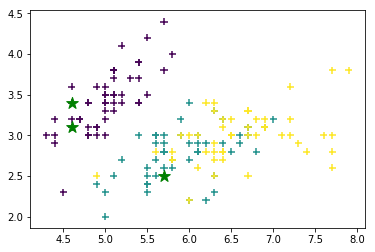

In [12]:
iris = datasets.load_iris()
X = iris.data[:, :2] 
y = iris.target

xmin1 = X[0].min()
xmin2 = X[1].min()
#print(xmin1,xmin2)

xmax1 = X[0].max()
xmax2 = X[1].max()
#print(xmax1,xmax2)

#xmean1 = X[0].mean()
#xmean2 = X[1].mean()
#print('mean',xmean1,xmean2)

#xstd1 = X[0].std()
#xstd2 = X[1].std()
#print('std',xstd1,xstd2)

#x_1 = np.random.uniform(low=xmin1, high=xmax1,size=3)
#x_2 = np.random.uniform(low=xmin2, high=xmax2,size=3)
df = pd.DataFrame(X)
centers = df.sample(3,random_state=2)
# print('sample')
# print(centers)
# print('************************')
# print(centers.iloc[0][0],centers.iloc[0][1])


#np.random.randint(low=1, high=100, size=4)
#np.random.randint(low=1, high=100, size=4)

k = 3

#centroids = np.array([[xmin1,xmin2], [xmean1,xmean2] ,[xmax1,xmax2]]) 
centroids = np.array([[centers.iloc[0][0],centers.iloc[0][1]], [centers.iloc[1][0],centers.iloc[1][1]] ,[centers.iloc[2][0],centers.iloc[2][1]]]) 
print(centroids)

plt.scatter(X[:,0], X[:,1],marker='+',c=y, s=50)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)




counter 0 delta_inertia 1
current_inertia 57.557089965172686 prev_inertia 1
counter 1 delta_inertia 56.557089965172686
current_inertia 51.40169599217988 prev_inertia 57.557089965172686
counter 2 delta_inertia 6.155393972992805
current_inertia 49.12424760601917 prev_inertia 51.40169599217988
counter 3 delta_inertia 2.2774483861607138
current_inertia 47.39728592545666 prev_inertia 49.12424760601917
counter 4 delta_inertia 1.7269616805625105
current_inertia 45.745424106274555 prev_inertia 47.39728592545666
counter 5 delta_inertia 1.651861819182102
current_inertia 44.350734364925856 prev_inertia 45.745424106274555
counter 6 delta_inertia 1.3946897413486994
current_inertia 43.60639348370927 prev_inertia 44.350734364925856
counter 7 delta_inertia 0.744340881216587
current_inertia 41.33018939393939 prev_inertia 43.60639348370927
counter 8 delta_inertia 2.2762040897698768
current_inertia 38.95803126213265 prev_inertia 41.33018939393939
counter 9 delta_inertia 2.372158131806742
current_inertia 

array([[5.006     , 3.428     ],
       [5.77358491, 2.69245283],
       [6.81276596, 3.07446809]])

final delta_inertia 0.0 counter 15


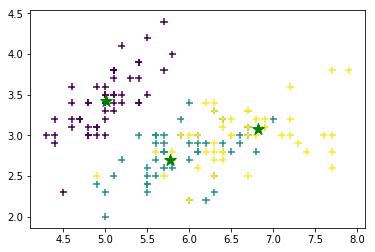

In [14]:
centroids_old = np.zeros(centroids.shape) # to store old centers
#display('centroids_old',centroids_old)
centroids_new = centroids.copy() # Store new centers
#display('centroids_new',centroids_new)

n = X.shape[0]
clusters = np.zeros(n)
distances = np.zeros((n,k))
inertia = np.zeros((k,1))
#display('clusters',clusters)
#display('distances',distances)

#print(centroids_new - centroids_old)
#print(((centroids_new - centroids_old)**2))
#print(((centroids_new - centroids_old)**2).sum(axis=1))

tolerance = 0.0001
prev_inertia, current_inertia = 0,1 

delta_inertia = np.abs(current_inertia - prev_inertia) #np.sqrt(((centroids_new - centroids_old)**2).sum(axis=1)) 
#display('error',error)
counter = 0
while delta_inertia > tolerance:
    print('counter', counter,'delta_inertia',delta_inertia)
    #display('X',X)
    for i in range(k):
    #         print(data - centroids[i])
    #         print(((data - centroids[i])**2))
    #         print(((data - centroids[i])**2).sum(axis=1))
    #         print(np.sqrt(((data - centroids[i])**2).sum(axis=1)))
        distances[:,i] = np.sqrt(((X - centroids_new[i])**2).sum(axis=1))
        #print('distances k=',i,distances[:,i])

    clusters = np.argmin(distances, axis = 1)
    #display('clusters argmin=',clusters)

    centroids_old = centroids_new.copy()

    for i in range(k):
#         print(X[clusters == 1])
#         print(np.mean(X[clusters == i], axis=0))
        centroids_new[i] = np.mean(X[clusters == i], axis=0)
   
        
    for i in range(k):
        
        idx = np.where(clusters==i)
        #print('idx',idx)
        inertia[i] = np.sum(((X[idx] - centroids_new[i])**2).sum(axis=1))
        #print('inertia',inertia)

    prev_inertia = current_inertia
    current_inertia = inertia.sum()
    delta_inertia = np.abs(current_inertia - prev_inertia)
    counter += 1
    print('current_inertia',current_inertia,'prev_inertia',prev_inertia)

display(centroids_new)
print('final delta_inertia',delta_inertia,'counter',counter)

plt.scatter(X[:,0], X[:,1],marker='+',c=y, s=50)
plt.scatter(centroids_new[:,0], centroids_new[:,1], marker='*', c='g', s=150)

#### Kmeans sample page 397

In [ ]:
k = 3

centroids = np.array([[0,0],[16,0],[16,6]],dtype=float)
data = np.array([[0,0],[8,0],[8,6],[16,0],[0,6],[16,6],[5,5]])


plt.scatter(data[:,0], data[:,1],marker='+', s=50)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)

    

In [ ]:
#run k = 1

centroids_old = np.zeros(centroids.shape) # to store old centers
display('centroids_old',centroids_old)
centroids_new = centroids.copy() # Store new centers
display('centroids_new',centroids_new)

n = data.shape[0]
clusters = np.zeros(n)
distances = np.zeros((n,k))
inertia = np.zeros((k,1))
#display('clusters',clusters)
#display('distances',distances)

#print(centroids_new - centroids_old)
#print(((centroids_new - centroids_old)**2))
#print(((centroids_new - centroids_old)**2).sum(axis=1))

tolerance = 0.0001
prev_inertia, current_inertia = 0,1 

delta_inertia = current_inertia - prev_inertia #np.sqrt(((centroids_new - centroids_old)**2).sum(axis=1)) 
#display('error',error)

while delta_inertia > tolerance:

    display('data',data)
    for i in range(k):
    #         print(data - centroids[i])
    #         print(((data - centroids[i])**2))
    #         print(((data - centroids[i])**2).sum(axis=1))
    #         print(np.sqrt(((data - centroids[i])**2).sum(axis=1)))
        distances[:,i] = np.sqrt(((data - centroids[i])**2).sum(axis=1))
        print('distances k=',i,distances[:,i])

    clusters = np.argmin(distances, axis = 1)
    display('clusters argmin=',clusters)

    centroids_old = centroids_new.copy()

    for i in range(k):
        print(np.mean(data[clusters == i], axis=0))
        centroids_new[i] = np.mean(data[clusters == i], axis=0)

    display(centroids_new)
    error -= 1 
    
    for i in range(k):
        
        idx = np.where(clusters==i)
        print('idx',idx)
        inertia[i] = np.sum(((data[idx] - centroids_new[i])**2).sum(axis=1))
        print('inertia',inertia)

    prev_inertia = current_inertia
    current_inertia = inertia.sum()
    delta_inertia = current_inertia - prev_inertia
    print('current_inertia',current_inertia)

print('final delta_inertia',delta_inertia)

plt.scatter(data[:,0], data[:,1],marker='+', s=50)
plt.scatter(centroids_new[:,0], centroids_new[:,1], marker='*', c='g', s=150)